In [1]:
# Imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Download MNIST Dataset
# torchvision.datasets.MNIST('./', download=True)

# AutoEncoder
- AutoEncoder is a type of unsupervised model
- This means that we don't train it on any labeled data
- Used for tasks like clustering and dimensionality reduction
- This is in contrast to supervised models which require labeled data, for tasks like regression and classification

### This project is an AutoEncoder for dimensionality reduction of the MNIST dataset

## Key Points
- **Latent Space/Embedding/Representation**: This is the lower dimensional representation of the data
- **Encoder**: The part of the model that maps the data to the latent space
- **Decoder**: The part of the model that tries to map the latent space back to the original data

## AutoEncoder Architecture:

<img src="https://www.compthree.com/images/blog/ae/ae.png" width="400"/>

# Data

In [3]:
images, ground_truth = torch.load('MNIST/processed/training.pt')

C:\Users\sudar\AppData\Local\Temp\ipykernel_12956\2029277582.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  images, ground_truth = torch.load('MNIST/processed/training.

In [4]:
print(images.shape) # 60,000 images of size 28x28
print(ground_truth.shape) # Array of length 60,000 for the ground truth

torch.Size([60000, 28, 28])
torch.Size([60000])


In [5]:
# Pixel values of an image are betweeen 0 to 255
print(torch.min(images[0]))
print(torch.max(images[0]))

tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)


tensor(3)


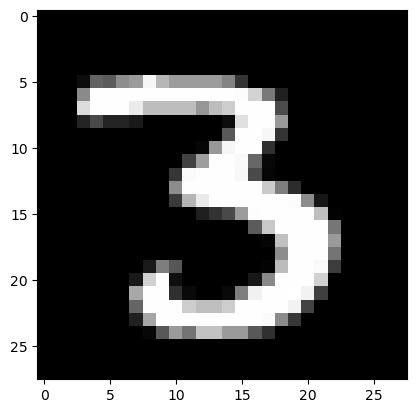

In [6]:
image_index = 12

print(ground_truth[image_index]) # Ground truth label
plt.imshow(images[image_index], cmap='gray') # Display the image

## Loading In The Data
PyTorch has two types of Datasets:
- **MAP-style**: For data that is easy to access with an index
- **Iterable-style**: For data to be streamed (video, text, etc.)

In [7]:
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    '''
    Creates a MAP-style PyTorch dataset
    Can query the dataset via index
    Need to implement __getitem__ and __len_ methods
    '''
    def __init__(self, path):
        # Load the data into memory
        # Don't do this if we have a lot of data
        self.images, self.ground_truth = torch.load(path)

    # When the data is in a .h5 file, we can read data everytime getitem is called since it's inexpensive in this case
    def __getitem__(self, index):
        # Returns image with index
        x = self.images[index].float()
        x = torch.Tensor(x)
        x = torch.flatten(x) # Flatten the image from 28x28 to 784
        
        return x

    def __len__(self):
        # Returns length of the dataset
        return len(self.ground_truth)

In [8]:
train_dataset = MNISTDataset('MNIST/processed/training.pt')
test_dataset = MNISTDataset('MNIST/processed/test.pt')

print('Train dataset length: ', len(train_dataset))
print('Test dataset length: ', len(test_dataset))

Train dataset length:  60000
Test dataset length:  10000


C:\Users\sudar\AppData\Local\Temp\ipykernel_12956\1831518809.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.images, self.ground_truth = torch.load(path)


In [9]:
train_dataset[15].shape

torch.Size([784])

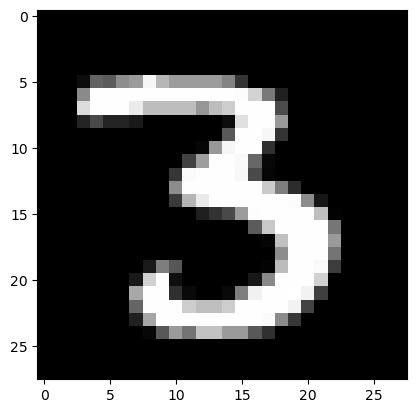

In [10]:
plt.imshow(train_dataset[12].numpy().reshape((28, 28)), cmap='gray')

# Building the AutoEncoder
- The network will have 4 fully connected layers, 2 for the encoder and 2 for the decoder
- The bottleneck layer in the middle of the model will force it to learn an efficient representation
- We train the model by minimizing the mean squared error between the reconstructed data and original data
$MSE =  \frac{1}{N} \sum_{i=1}^{n}(X_i - \hat{X}_i)^2$
---
- The input dimension will be of size 784, which is all of the pixels in the image
- The latent dimension is of size 128
- Since the size of the latent space is much smaller, it will force the model to learn an efficient representation
- This is because all the information the decoder has to reconstruct the image is from the latent space, so it has to figure out a way to learn a better representation of the data
---
- There are other versions of AutoEncoders where the latent dimension is bigger than the input dimension and this is used as a denoising AutoEncoder
---
> How do we train the model

- We want to minimize the distance between the image that we're reconstructing and the original input image
- An easy loss function to use is MSE

In [11]:
import torch.nn as nn # Submodule for neural network building blocks

# This uses linear layers
# For VAE, we will use a convolutional network
class AutoEncoder(nn.Module):
    '''
    AutoEncoder with fully connected layers

    Parameters
    input_shape - Shape of the input data
    latent_dim - Size of the latent dimension
    '''

    def __init__(self, input_shape, latent_dim=128):
        super().__init__() # 

        # Two fully connected layers for encoder (input_shape -> latent_dim)
        self.encoder_l1 = nn.Linear(in_features=input_shape, out_features=latent_dim)
        self.encoder_l2 = nn.Linear(in_features=latent_dim, out_features=latent_dim)

        # Two fully connected layers for decoder (128 -> input_shape)
        self.decoder_l1 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
        self.decoder_l2 = nn.Linear(in_features=latent_dim, out_features=input_shape)

    def forward(self, x):
        '''
        Define how the network is going to be run

        Parameters
        x - Input data

        Returns
        x_hat - Reconstructed data
        '''

        latent = self.run_encoder(x)
        x_hat = self.run_decoder(latent)
        return x_hat

    def run_encoder(self, x):
        # Runs encoder
        output = F.relu(self.encoder_l1(x))
        latent = F.relu(self.encoder_l2(output)) # Latent representation
        return latent

    def run_decoder(self, latent):
        # Runs decoder
        output = F.relu(self.decoder_l1(latent))
        x_hat = F.relu(self.decoder_l2(output)) # Reconstructed image
        return x_hat

In [12]:
train_dataset = MNISTDataset('MNIST/processed/training.pt')
test_dataset = MNISTDataset('MNIST/processed/test.pt')

# Shape of the input data
image_shape = train_dataset[0].shape[0]
print(image_shape)

# Initialize AutoEncoder
model = AutoEncoder(input_shape=image_shape)

# Save the model onto the GPU
model.cuda() # By default the model is going to be on the CPU

784


C:\Users\sudar\AppData\Local\Temp\ipykernel_12956\1831518809.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.images, self.ground_truth = torch.load(path)


AutoEncoder(
  (encoder_l1): Linear(in_features=784, out_features=128, bias=True)
  (encoder_l2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l1): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l2): Linear(in_features=128, out_features=784, bias=True)
)

## eval() and train() mode
- In PyTorch, the model can be in two modes, eval() and train()
- Some layers like BatchNorm and Dropout perform differntly in each mode
- The model is in train() mode by default

In [13]:
model.train()

AutoEncoder(
  (encoder_l1): Linear(in_features=784, out_features=128, bias=True)
  (encoder_l2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l1): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l2): Linear(in_features=128, out_features=784, bias=True)
)

## Defining the loss, optimizer and training loop

In [14]:
import torch.optim as optim

# Training data loader, iterates over our dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# MSE loss
mse = nn.MSELoss()

# Create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 100

for epoch in range(n_epochs):
    loss = 0

    # batch_features is each training batch of shape (batch_size x n_features), here, (128, 784)

    for batch_features in train_loader:
        # Put data onto GPU
        batch_features = batch_features.cuda()

        # Reset the gradient back to 0
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # Forward pass, compute reconstructions
        outputs = model(batch_features)

        # Compute training reconstruction loss
        train_loss = mse(outputs, batch_features)

        # Compute accumulated gradients
        train_loss.backward()

        # Perform parameter update based on current gradients
        optimizer.step()

        # Add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # Compute the epoch training loss
    loss = loss / len(train_loader)

    if epoch % 5 == 0:
        print(f'epoch: {epoch + 1}/{n_epochs}, loss {loss:.6f}')

print(f'epoch: {epoch + 1}/{n_epochs}, loss {loss:.6f}')

epoch: 1/100, loss 1999.889519
epoch: 6/100, loss 829.232850
epoch: 11/100, loss 754.969207
epoch: 16/100, loss 719.279357
epoch: 21/100, loss 697.177392
epoch: 26/100, loss 684.775553
epoch: 31/100, loss 675.001399
epoch: 36/100, loss 668.111029
epoch: 41/100, loss 662.859575
epoch: 46/100, loss 658.404973
epoch: 51/100, loss 654.367721
epoch: 56/100, loss 651.014255
epoch: 61/100, loss 648.571642
epoch: 66/100, loss 646.525505
epoch: 71/100, loss 644.683556
epoch: 76/100, loss 641.886895
epoch: 81/100, loss 640.491811
epoch: 86/100, loss 639.006832
epoch: 91/100, loss 638.004036
epoch: 96/100, loss 637.952569
epoch: 100/100, loss 637.637544


## Evaluating the model
We can visually see how well the model does at reconstructing the input image

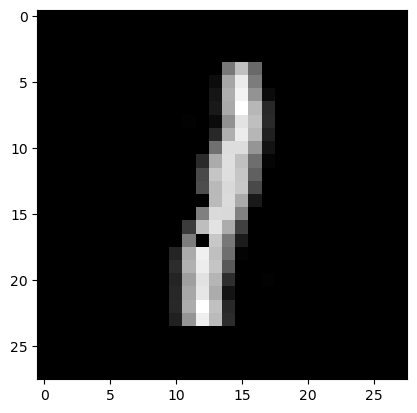

In [15]:
# Put the model into eval() mode
model.eval()

# Visuazlie the output of the train set
image_index = 231

image = train_dataset[image_index].cuda()
x_hat = model(image)
x_hat = x_hat.detach().cpu().numpy().reshape((28, 28))
x_hat = np.around(x_hat)

plt.imshow(x_hat, cmap='gray') # Reconstructed image

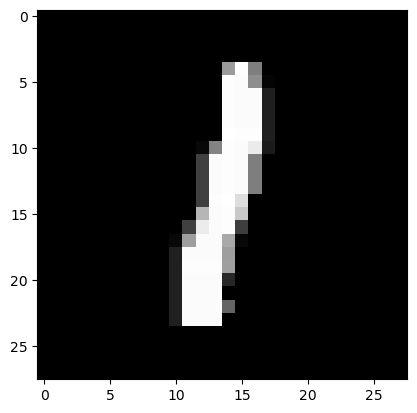

In [16]:
plt.imshow(image.cpu().reshape((28, 28)), cmap='gray') # Original input image

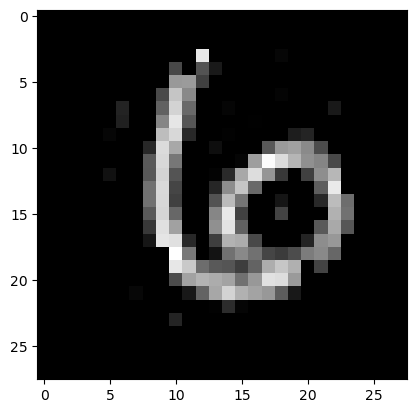

In [17]:
# Visualizing Test Images
image_index = 100

image = test_dataset[image_index].cuda()
x_hat = model(image)
x_hat = x_hat.detach().cpu().numpy().reshape((28, 28))
x_hat = np.around(x_hat)

plt.imshow(x_hat, cmap='gray') # Reconstructed image

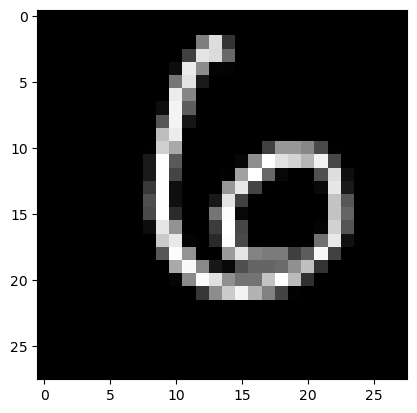

In [18]:
plt.imshow(image.cpu().reshape((28, 28)), cmap='gray') # Original input image

## Latent Representation
Now that the model is trained, we can get the latent representation of the data which can then be fed to downstream tasks

In [19]:
# torch.no_grad() doesns't compute gradient
@torch.no_grad()
def get_latent_representation(model, dataloader):
    latent_representation = []
    
    for batch in dataloader:
        batch = batch.cuda()
        # Run only the encoder
        latent = model.run_encoder(batch)
        latent = latent.cpu().numpy()
        latent_representation.append(latent)

    latent_representation = np.concatenate(latent_representation)
    
    return latent_representation

latent = get_latent_representation(model, train_loader)
latent.shape

# Now, we can build a classifier on top of the latent space, run unsupervised clustering, etc.

(60000, 128)

# Extending to a Variational AutoEncoder
- What if we want to generate images? What if we want to impose some constraints on the latent space?
- In our AutoEncoder, we had no constraints on the latent space. Now, the latent space will be constrained to be drawn from the normal distribution
- Instead of the encoder directly outputting the latent space, it will output a vector of means and a vector of variances from which we sample our latent space
- This has the following benefits:
    1. We have constraints on the latent space and can specify priors on our latent variables
    2. It's now a generative model
- From the graphical model's perspective, this is known as amortized variational inference (using a neural network to learn parameters of the distribution)

## Variational AutoEncoder Architecture

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*CAHY9d6wDAcrftSzd421YA.png" width="400"/>